라이브러리

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [5]:
CSV_PATH = 'daily_sales.csv'

df = pd.read_csv(CSV_PATH, parse_dates=['date'])
df['roll_mean_5'] = df['sales'].rolling(5).mean()
df['roll_mean_20'] = df['sales'].rolling(20).mean()
df.tail()

,date,sales,price,promo,roll_mean_5,roll_mean_20
725,2023-12-27,81.77,9.95,0,73.284,72.2445
726,2023-12-28,74.44,9.70,0,74.422,72.2295
727,2023-12-29,66.65,9.44,1,74.422,72.3600
728,2023-12-30,72.82,9.22,0,75.162,72.8185
729,2023-12-31,67.41,9.41,0,72.618,72.4210


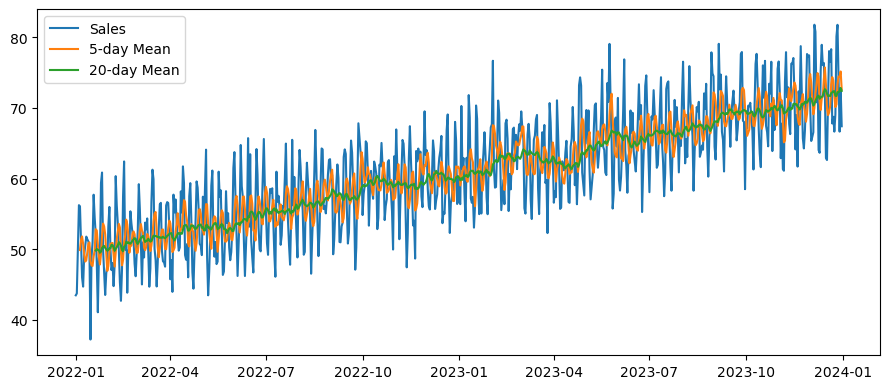

In [8]:
# 추세 시각화
plt.figure(figsize=(9,4))
plt.plot(df['date'], df['sales'], label='Sales')
plt.plot(df['date'], df['roll_mean_5'], label='5-day Mean')
plt.plot(df['date'], df['roll_mean_20'], label='20-day Mean')
plt.legend()
plt.tight_layout()
plt.show()

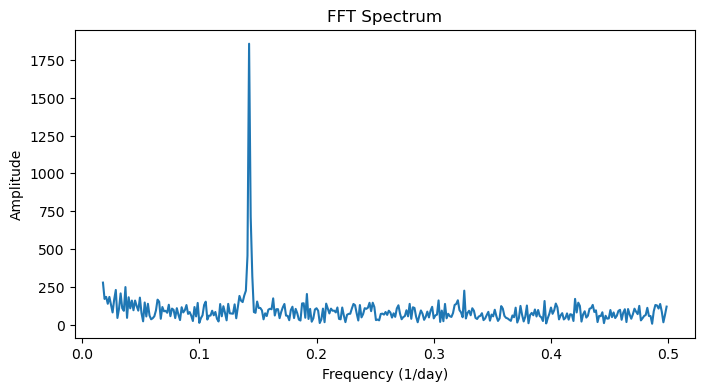

Dominant Frequency = 0.1425 (1/day)
Dominant Period = 7.02 days


In [ ]:
# 계절성 확인을 위한 주기 시각화
from scipy.fft import fft, fftfreq

# 1) 데이터 준비
y = df['sales'] - df['sales'].mean()   # 평균 제거 (DC 성분 제거)
N = len(y)                             # 데이터 개수
d = 1                                  # 샘플 간격 (1일 단위 데이터면 1)

# 2) FFT 수행
yf = np.abs(fft(y))
xf = fftfreq(N, d=d)

# 3) 양의 주파수만 선택
pos_mask = xf > 0
xf = xf[pos_mask]
yf = yf[pos_mask]

# 4) 저주파(장기 추세) 제거
#  예: 60일보다 긴 주기(즉, 1/60 이하 주파수)는 무시
fmin = 1/60    # cutoff frequency
mask = xf >= fmin
xf = xf[mask]
yf = yf[mask]

# 5) 스펙트럼 시각화
plt.figure(figsize=(8,4))
plt.plot(xf, yf)
plt.title('FFT Spectrum')
plt.xlabel('Frequency (1/day)')
plt.ylabel('Amplitude')
plt.show()

# 6) 가장 강한 주파수 찾기
dominant_idx = np.argmax(yf)
dominant_freq = xf[dominant_idx]
dominant_period = 1 / dominant_freq

print(f"Dominant Frequency = {dominant_freq:.4f} (1/day)")
print(f"Dominant Period = {dominant_period:.2f} days")

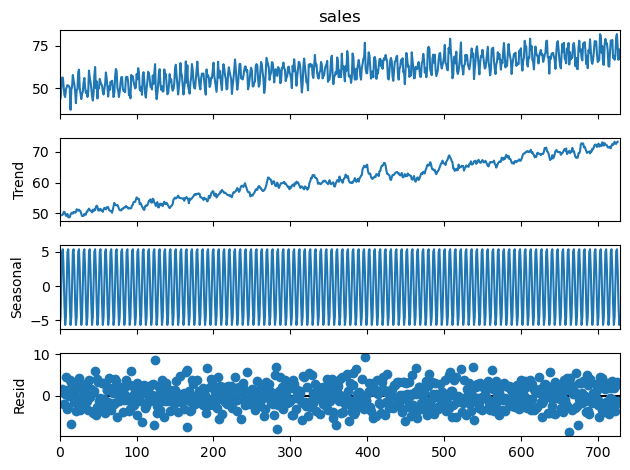

In [ ]:
# 종합적으로 시각화
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['sales'], model='additive', period=7) 
result.plot()
plt.show()

추세 : 점차 상향하는 추세를 보임

계절성 : 7일 주기의 계절성을 보임

In [18]:
# 타겟 컬럼 생성
df['target_next'] = df['sales'].shift(-1)
df = df.dropna().reset_index(drop=True)
df

,date,sales,price,promo,roll_mean_5,roll_mean_20,target_next
0,2022-01-20,52.08,10.44,0,52.832,49.8210,48.02
1,2022-01-21,48.02,10.15,1,52.654,50.0480,41.08
2,2022-01-22,41.08,10.42,0,50.680,49.9150,48.79
3,2022-01-23,48.79,10.86,1,48.894,49.8595,49.24
4,2022-01-24,49.24,10.52,0,47.842,49.5095,59.39
...,...,...,...,...,...,...,...
705,2023-12-26,80.13,9.69,1,70.490,71.6965,81.77
706,2023-12-27,81.77,9.95,0,73.284,72.2445,74.44
707,2023-12-28,74.44,9.70,0,74.422,72.2295,66.65
708,2023-12-29,66.65,9.44,1,74.422,72.3600,72.82


In [19]:
feature_cols = [ c for c in df.columns if c not in ['date','sales','target_next']]
cut = int(len(df) * 0.8) # train/test 셋을 나누는 기준선

train, valid = df.iloc[:cut].copy(), df.iloc[cut:].copy()

X_tr, y_tr = train[feature_cols], train['target_next']
X_va, y_va = valid[feature_cols], valid['target_next']
(len(X_tr), len(X_va))

(568, 142)